# Predicting the State of a Kickstarter Project
What determines if a Kickstarter project will result in a successful project? By definition, a "successful" project is one that meets or exceeds it's fundraising goal. From performing arts that need funding for production, to entrepreneurs looking to strike gold with the next greatest app or product, what are the factors that will influence a successful project? I set out to explore the data on past Kickstarter projects since the beginning through the year 2018 to see what insights we can find while digging into the data. After exploring the data, I'll create a model to predict the state a Kickstarter project will result in. The goal is to learn as much as we can about successful projects in hope of helping others create a successful Kickstarter project of their own in the future.

In [1]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier


In [2]:
#dataframe display options

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)

In [3]:
# Import the entire dataset into a dataframe
df = pd.read_csv('data/ks-projects-201801.csv')

df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,"1,000.00",2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,"1,533.95"
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,"30,000.00",2017-09-02 04:43:57,"2,421.00",failed,15,US,100.00,"2,421.00","30,000.00"
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,"45,000.00",2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,"45,000.00"
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,"5,000.00",2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,"5,000.00"
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,"19,500.00",2015-07-04 08:35:03,"1,283.00",canceled,14,US,"1,283.00","1,283.00","19,500.00"


In [4]:
#check datatypes of attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [5]:
#sum count of nulls per attribute
df.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [6]:
#percentage of nulls per attribute
(df.isnull().sum().values / df.count())*100

ID                 0.00
name               0.00
category           0.00
main_category      0.00
currency           0.00
deadline           0.00
goal               0.00
launched           0.00
pledged            0.00
state              0.00
backers            0.00
country            0.00
usd pledged        1.01
usd_pledged_real   0.00
usd_goal_real      0.00
dtype: float64

In [7]:
#value counts of state attribute
df['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [8]:
#percentage of value counts of state attribute
(df['state'].value_counts() / df['state'].count())*100

failed       52.22
successful   35.38
canceled     10.24
undefined     0.94
live          0.74
suspended     0.49
Name: state, dtype: float64

## Data Cleaning and EDA

The goal is to dive deeper into the respective project states to learn more about the trends and insights of each state. Some questions we are looking to answer are as follows:

* descriptive statistics per state
* distribution of project categories
* relationships to pledged amount

In [55]:
#converting launch string to datetime type, #format="%Y/%m/%d"
df['launched_timestamp'] = pd.to_datetime(df['launched'], infer_datetime_format=True)
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,launched_timestamp,deadline_timestamp,launch_year
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,"1,000.00",2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,"1,533.95",2015-08-11 12:12:28,2015-10-09,2015
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,"30,000.00",2017-09-02 04:43:57,"2,421.00",failed,15,US,100.00,"2,421.00","30,000.00",2017-09-02 04:43:57,2017-11-01,2017
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,"45,000.00",2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,"45,000.00",2013-01-12 00:20:50,2013-02-26,2013
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,"5,000.00",2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,"5,000.00",2012-03-17 03:24:11,2012-04-16,2012
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,"19,500.00",2015-07-04 08:35:03,"1,283.00",canceled,14,US,"1,283.00","1,283.00","19,500.00",2015-07-04 08:35:03,2015-08-29,2015


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 18 columns):
ID                    378661 non-null int64
name                  378657 non-null object
category              378661 non-null object
main_category         378661 non-null object
currency              378661 non-null object
deadline              378661 non-null object
goal                  378661 non-null float64
launched              378661 non-null object
pledged               378661 non-null float64
state                 378661 non-null object
backers               378661 non-null int64
country               378661 non-null object
usd pledged           374864 non-null float64
usd_pledged_real      378661 non-null float64
usd_goal_real         378661 non-null float64
launched_timestamp    378661 non-null datetime64[ns]
deadline_timestamp    378661 non-null datetime64[ns]
launch_year           378661 non-null int64
dtypes: datetime64[ns](2), float64(5), int64(3), object(8)
me

In [57]:
#converting deadline string to datatime type
df['deadline_timestamp'] = pd.to_datetime(df['deadline'], infer_datetime_format=True)
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,launched_timestamp,deadline_timestamp,launch_year
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,"1,000.00",2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,"1,533.95",2015-08-11 12:12:28,2015-10-09,2015
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,"30,000.00",2017-09-02 04:43:57,"2,421.00",failed,15,US,100.00,"2,421.00","30,000.00",2017-09-02 04:43:57,2017-11-01,2017
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,"45,000.00",2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,"45,000.00",2013-01-12 00:20:50,2013-02-26,2013
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,"5,000.00",2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,"5,000.00",2012-03-17 03:24:11,2012-04-16,2012
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,"19,500.00",2015-07-04 08:35:03,"1,283.00",canceled,14,US,"1,283.00","1,283.00","19,500.00",2015-07-04 08:35:03,2015-08-29,2015


In [11]:
#create launch year attribute
df['launch_year']=pd.to_datetime(df['launched_timestamp'], format="%Y/%m/%d").dt.year
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,launched_timestamp,deadline_timestamp,launch_year
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,"1,000.00",2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,"1,533.95",2015-08-11,2015-10-09,2015
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,"30,000.00",2017-09-02 04:43:57,"2,421.00",failed,15,US,100.00,"2,421.00","30,000.00",2017-09-02,2017-11-01,2017
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,"45,000.00",2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,"45,000.00",2013-01-12,2013-02-26,2013
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,"5,000.00",2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,"5,000.00",2012-03-17,2012-04-16,2012
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,"19,500.00",2015-07-04 08:35:03,"1,283.00",canceled,14,US,"1,283.00","1,283.00","19,500.00",2015-07-04,2015-08-29,2015


### Descriptive statistics

Before diving in, let's just get a summary of how all the projects have faired over the years. Over 52% of projects started have ended up failing, while only 35% ended up being successful. We will look into these states to see if we can determine what factors may lead to a successful project.

In [12]:
#describe of the current data numerical attributes

df.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,launch_year
count,"378,661.00","378,661.00","378,661.00","378,661.00","374,864.00","378,661.00","378,661.00","378,661.00"
mean,"1,074,731,191.99","49,080.79","9,682.98",105.62,"7,036.73","9,058.92","45,454.40","2,014.25"
std,"619,086,204.32","1,183,391.26","95,636.01",907.19,"78,639.75","90,973.34","1,152,950.06",1.93
min,"5,971.00",0.01,0.00,0.00,0.00,0.00,0.01,"1,970.00"
25%,"538,263,516.00","2,000.00",30.00,2.00,16.98,31.00,"2,000.00","2,013.00"
50%,"1,075,275,634.00","5,200.00",620.00,12.00,394.72,624.33,"5,500.00","2,014.00"
75%,"1,610,148,624.00","16,000.00","4,076.00",56.00,"3,034.09","4,050.00","15,500.00","2,016.00"
max,"2,147,476,221.00","100,000,000.00","20,338,986.27","219,382.00","20,338,986.27","20,338,986.27","166,361,390.71","2,018.00"


In [13]:
#desribe per state of usd pledge real

df.groupby('state').usd_pledged_real.describe()

,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
canceled,"38,779.00","2,340.52","13,524.02",0.00,0.00,87.00,906.54,"1,076,751.05"
failed,"197,719.00","1,320.60","6,820.25",0.00,2.64,100.00,663.00,"757,352.94"
live,"2,799.00","5,869.17","31,430.56",0.00,10.00,259.16,"1,798.00","724,423.80"
successful,"133,956.00","22,670.80","151,090.32",0.79,"2,000.00","5,107.25","13,232.08","20,338,986.27"
suspended,"1,846.00","9,312.38","99,313.84",0.00,0.00,37.00,"1,354.97","4,005,111.42"
undefined,"3,562.00","2,212.86","2,751.80",0.00,4.52,580.00,"3,931.50","14,997.93"


In [14]:
df.groupby('state').usd_pledged_real.agg(['median', 'mean'])

,median,mean
state,,
canceled,87.00,"2,340.52"
failed,100.00,"1,320.60"
live,259.16,"5,869.17"
successful,"5,107.25","22,670.80"
suspended,37.00,"9,312.38"
undefined,580.00,"2,212.86"


In [15]:
#desribe per state of usd goal real

df.groupby('state').usd_goal_real.describe()

,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
canceled,"38,779.00","75,579.42","1,281,388.94",0.01,"3,290.09","10,000.00","30,000.00","100,000,000.00"
failed,"197,719.00","63,174.74","1,435,682.63",0.15,"2,500.00","7,500.00","20,000.00","166,361,390.71"
live,"2,799.00","62,535.28","1,875,467.85",1.00,"2,052.68","6,547.09","18,505.49","99,000,000.00"
successful,"133,956.00","9,532.85","27,961.44",0.01,"1,301.91","3,837.74","10,000.00","2,015,608.88"
suspended,"1,846.00","175,208.01","3,444,548.29",0.58,"1,000.00","5,000.00","20,000.00","100,000,000.00"
undefined,"3,562.00","4,103.02","2,792.08",85.28,"2,238.60","3,530.43","5,038.16","77,357.47"


In [16]:
df.groupby('state').usd_goal_real.agg(['median', 'mean'])

,median,mean
state,,
canceled,"10,000.00","75,579.42"
failed,"7,500.00","63,174.74"
live,"6,547.09","62,535.28"
successful,"3,837.74","9,532.85"
suspended,"5,000.00","175,208.01"
undefined,"3,530.43","4,103.02"


In [26]:
#mode of usd_goal_real in successful projects, and percentage of total successful projects
(df.loc[df.state=='successful'].usd_goal_real.value_counts().head()) / (df.loc[df.state=='successful'].usd_goal_real.count()) * 100

5,000.00    6.24
10,000.00   4.90
1,000.00    4.37
3,000.00    4.14
2,000.00    3.97
Name: usd_goal_real, dtype: float64

In [27]:
df.loc[df.state=='successful'].usd_goal_real.nunique()

20354

In [17]:
#desribe per state of backers

df.groupby('state').backers.describe()

,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
canceled,"38,779.00",25.99,136.07,0.00,0.00,3.00,15.00,"9,326.00"
failed,"197,719.00",16.42,71.22,0.00,1.00,3.00,12.00,"6,550.00"
live,"2,799.00",68.10,382.56,0.00,1.00,5.00,26.00,"10,748.00"
successful,"133,956.00",263.92,"1,504.58",0.00,33.00,71.00,167.00,"219,382.00"
suspended,"1,846.00",105.08,750.53,0.00,0.00,2.00,19.00,"20,632.00"
undefined,"3,562.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [18]:
df.groupby('state').backers.agg(['median', 'mean'])

,median,mean
state,,
canceled,3,25.99
failed,3,16.42
live,5,68.10
successful,71,263.92
suspended,2,105.08
undefined,0,0.00


In [29]:
#mode of backers in successful projects, and percentage of total successful projects
(df.loc[df.state=='successful'].backers.value_counts().head()) / (df.loc[df.state=='successful'].backers.count()) * 100

19   1.01
22   0.97
23   0.97
21   0.95
18   0.95
Name: backers, dtype: float64

First looking at "usd_goal_real" attribute, successful projects on average have a usd goal of around 9,500. This is misleading though, as the mean is heavily affected by outliers, which we can see with a 2 million + project goal. For this reason, the median value is a better measure of usd goal amounts for successful vs failed projects. The median usd goal real value for successful project is about $3,800.00, while failed projects median usd goal real value is 7,500. Looking into the mode of "usd_goal_real" in successful projects, we see the mode as 5,000 dollars, at about 6% of succesful projects. There seemes to be quite a bit of range though of successful project goal amounts, with a little over 23,000 unique goal amounts of the almost 134,000 successful projects.

It's interesting to see that for successful projects, median backer amount is 71, while median backer amount for canceled and failed projects is 3. We will stay away from mean values in this dataset for the most part due to some outlier projects that ended up being uber successful. If we were to look into the mode of backers in successful projects, we will see a mode of 19 backers at only 1% of total successful projects.

There definitely seems to be a lot of variance of what makes a succesful project as it relates to "usd_goal_real" and "backers", two attributes you would think you would aim and set goals for accordingly. You probably don't want to set too large of a goal if your hopes are strictly a "successful" funded project, as you don't want to discourage others from pledging to your project. Of course, the type of project your are running will heavily influence you setting a realistic goal for your project. With that, let's take a look into the project categories.

### Distribution of project categories

In [59]:
#calculating duration of each project in days
df['duration_days'] = pd.Series(delta.days for delta in (df['deadline_timestamp'] - df['launched_timestamp']))
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,launched_timestamp,deadline_timestamp,launch_year,duration_days
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,"1,000.00",2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,"1,533.95",2015-08-11 12:12:28,2015-10-09,2015,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,"30,000.00",2017-09-02 04:43:57,"2,421.00",failed,15,US,100.00,"2,421.00","30,000.00",2017-09-02 04:43:57,2017-11-01,2017,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,"45,000.00",2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,"45,000.00",2013-01-12 00:20:50,2013-02-26,2013,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,"5,000.00",2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,"5,000.00",2012-03-17 03:24:11,2012-04-16,2012,29
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,"19,500.00",2015-07-04 08:35:03,"1,283.00",canceled,14,US,"1,283.00","1,283.00","19,500.00",2015-07-04 08:35:03,2015-08-29,2015,55


In [60]:
#create 3 new dataframes per states successful, canceled, and failed

failed = df.loc[df.state=='failed']
successful = df.loc[df.state=='successful']
canceled = df.loc[df.state=='canceled']

In [130]:
#of successful projects, count usd goal real of main category
temp = successful.groupby('main_category').count()['usd_goal_real']
temp = temp.sort_values(ascending=False).head()
print(temp)

main_category
Music           24197
Film & Video    23623
Games           12518
Publishing      12300
Art             11510
Name: usd_goal_real, dtype: int64


In [131]:
#sns.palplot(sns.color_palette())

Text(0.5,1,'top 5 main categories of successful projects')

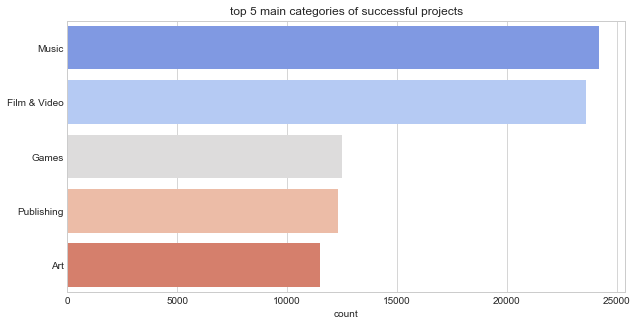

In [134]:
plt.figure(figsize=(10,5))
sns.barplot(x=temp, y=temp.index, palette='coolwarm');
plt.ylabel('');
plt.xlabel('count');
plt.title('top 5 main categories of successful projects')

In [136]:
#of successful projects, median backers of main category
temp = successful.groupby('main_category').median()['backers']
temp = temp.sort_values(ascending=False).head()
temp

main_category
Games        220.00
Technology   192.00
Design       168.00
Comics       101.00
Food          96.00
Name: backers, dtype: float64

Text(0.5,1,'Top 5 median backer count of main_category')

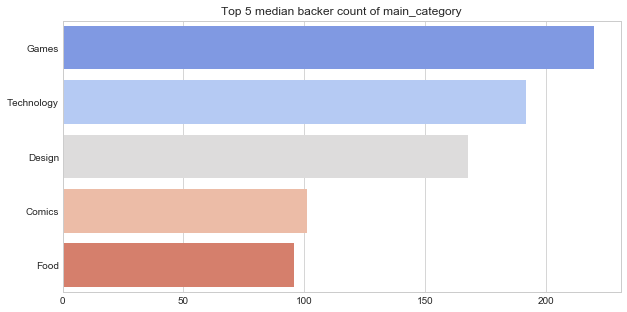

In [138]:
plt.figure(figsize=(10,5))
sns.barplot(x=temp, y=temp.index, palette='coolwarm');
plt.ylabel('');
plt.xlabel('');
plt.title('Top 5 median backer count of main_category')

In [139]:
#of failed projects, median usd_goal_real of main category
temp = failed.groupby('main_category').count()['usd_goal_real']
temp = temp.sort_values(ascending=False).head()
temp

main_category
Film & Video    32904
Publishing      23145
Music           21752
Technology      20616
Games           16003
Name: usd_goal_real, dtype: int64

Text(0.5,1,'top 5 main categories of failed projects')

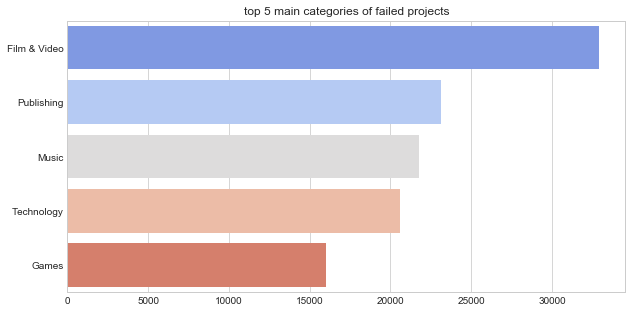

In [143]:
plt.figure(figsize=(10,5))
sns.barplot(x=temp, y=temp.index, palette='coolwarm');
plt.ylabel('');
plt.xlabel('');
plt.title('top 5 main categories of failed projects')

In [144]:
# # Top 5 performers by Fans
# temp = df.sort_values(by='usd_pledged_real', ascending=False).head()
# g = sns.barplot('usd_pledged_real', 'name', data=temp, palette='coolwarm');
# plt.ylabel('');

In [10]:
#view column headers in list form
list(df.columns.values.tolist())

['ID',
 'name',
 'category',
 'main_category',
 'currency',
 'deadline',
 'goal',
 'launched',
 'pledged',
 'state',
 'backers',
 'country',
 'usd pledged',
 'usd_pledged_real',
 'usd_goal_real',
 'launched_timestamp',
 'deadline_timestamp',
 'duration_days']

In [11]:
#dropping unneccesary columns
#dropping usd pledged since converion has errors
#dropping goal since usd goal real matches all other usd attributes
df.drop(['goal','deadline', 'launched', 'usd pledged', 'launched_timestamp', 'deadline_timestamp'], axis=1, inplace=True)
df.head()

,ID,name,category,main_category,currency,pledged,state,backers,country,usd_pledged_real,usd_goal_real,duration_days
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,0.0,failed,0,GB,0.0,1533.95,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2421.0,failed,15,US,2421.0,30000.00,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,220.0,failed,3,US,220.0,45000.00,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,1.0,failed,1,US,1.0,5000.00,29
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,1283.0,canceled,14,US,1283.0,19500.00,55


In [12]:
#drop all nulls in the dataset
df.dropna(inplace=True)
#sum count of nulls per attribute
df.isnull().sum()

ID                  0
name                0
category            0
main_category       0
currency            0
pledged             0
state               0
backers             0
country             0
usd_pledged_real    0
usd_goal_real       0
duration_days       0
dtype: int64

In [13]:
#df.drop(['name'], axis=1, inplace=True)
#df.head()

In [14]:
#dropping more unncessary columns
#dropping currency since we are only keeping all usd type attributes for consistency
#dropping pledge related attributes since if greater or equal to goal will always result in success
df.drop(['pledged', 'currency', 'usd_pledged_real'], axis=1, inplace=True)
df.head()

,ID,name,category,main_category,state,backers,country,usd_goal_real,duration_days
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,failed,0,GB,1533.95,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,failed,15,US,30000.00,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,failed,3,US,45000.00,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,failed,1,US,5000.00,29
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,canceled,14,US,19500.00,55


In [15]:
#label encode the state attribute
le = LabelEncoder()
le.fit(df['state'])
df['state_encoded'] = le.transform(df['state'])
df['state_encoded'].value_counts()

1    197716
3    133956
0     38779
5      3562
2      2799
4      1845
Name: state_encoded, dtype: int64

In [16]:
#view dataset
df.head()

,ID,name,category,main_category,state,backers,country,usd_goal_real,duration_days,state_encoded
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,failed,0,GB,1533.95,58,1
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,failed,15,US,30000.00,59,1
2,1000004038,Where is Hank?,Narrative Film,Film & Video,failed,3,US,45000.00,44,1
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,failed,1,US,5000.00,29,1
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,canceled,14,US,19500.00,55,0


In [17]:
# One hot encode the categorical columns
df_category_onehot = pd.get_dummies(df['category'], 
                                     prefix='category')

df_main_category_onehot = pd.get_dummies(df['main_category'], 
                                prefix='main_cat')

df_country_onehot = pd.get_dummies(df['country'], 
                                   prefix='country')


In [18]:
#concat the original df with the one hot encoded dfs
df_encoded = pd.concat([df, 
                        df_category_onehot, 
                        df_main_category_onehot, 
                        df_country_onehot], axis=1)

df_encoded.shape

(378657, 207)

In [19]:
df_orig = df_encoded[['ID', 'name', 'state', 'state_encoded']]
df_orig.head()

,ID,name,state,state_encoded
0,1000002330,The Songs of Adelaide & Abullah,failed,1
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,failed,1
2,1000004038,Where is Hank?,failed,1
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,failed,1
4,1000011046,Community Film Project: The Art of Neighborhoo...,canceled,0


In [20]:
#drop more attributes to finalize the dataset ready for training
df_encoded.drop(['ID', 'name', 'category', 'main_category', 'country'], axis=1, inplace=True)
df_encoded.head()

,state,backers,usd_goal_real,duration_days,state_encoded,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,failed,0,1533.95,58,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,failed,15,30000.00,59,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,failed,3,45000.00,44,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,failed,1,5000.00,29,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,canceled,14,19500.00,55,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Machine Learning

In [21]:
df_cleaned = df_encoded

In [22]:
train_set, test_set = train_test_split(df_cleaned, test_size = .2, random_state=42)

In [23]:
#splitting to data and labels
X_train = train_set.drop(['state', 'state_encoded'], axis=1) # data
y_train = train_set.state_encoded # labels

In [24]:
X_train.shape

(302925, 200)

In [25]:
y_train.shape

(302925,)

In [26]:
#create function to fit model, cross validate, and get accuracies
def fit_algo(algo, X_train, y_train, cv):
    
    
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

In [27]:
#create instance of log reg 
#lr_model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
lr_model = LogisticRegression()

In [28]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_algo(lr_model, X_train, y_train, 10)
log_time = (time.time() - start_time)


print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 77.24
Accuracy CV 10-Fold: 77.19
Running Time: 0:02:21.563680


In [29]:
models = pd.DataFrame({
    'Model_Name': ['Logistic Regression'],
    'Reg_Accuracy_Score': [ 
        acc_log,  
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Reg_Accuracy_Score', ascending=False)

---Reuglar Accuracy Scores---


,Model_Name,Reg_Accuracy_Score
0,Logistic Regression,77.24


In [30]:
cv_models = pd.DataFrame({
    'Model_Name': ['Logistic Regression'],
    'CV_Accuracy_Score': [ 
        acc_cv_log,      
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='CV_Accuracy_Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model_Name,CV_Accuracy_Score
0,Logistic Regression,77.19


In [32]:
#splitting test data to data and labels
X_test = test_set.drop(['state', 'state_encoded'], axis=1) # data
y_test = test_set.state_encoded # labels

In [33]:
X_test.shape

(75732, 200)

In [34]:
y_test.shape

(75732,)

In [36]:
predictions = lr_model.predict(X_test)
df_predictions = pd.DataFrame({
                               "State": test_set['state'],
                               "Actual_State_Encoded": y_test,
                               "Prediction": predictions})

df_predictions



,State,Actual_State_Encoded,Prediction
266682,failed,1,1
179492,successful,3,3
179755,successful,3,3
195374,failed,1,1
161413,successful,3,3
281802,failed,1,1
357031,successful,3,3
66123,suspended,4,1
212120,canceled,0,1
235566,successful,3,3


In [37]:
test_accuracy = round(metrics.accuracy_score(y_test, predictions) * 100, 2)
test_accuracy

77.25

In [38]:
print(metrics.classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.22      0.00      0.00      7814
          1       0.72      0.96      0.82     39359
          2       0.00      0.00      0.00       531
          3       0.90      0.76      0.82     26942
          4       0.04      0.00      0.00       394
          5       0.94      0.51      0.66       692

avg / total       0.72      0.77      0.73     75732

